In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

2024-07-20 05:48:22.563010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 05:48:22.563107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 05:48:22.682132: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
feature_extraction_model = VGG16(weights='imagenet', include_top=False, pooling='max')
feature_extraction_model.summary()

for layer in feature_extraction_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
"""# Function to extract features from images
def extract_features(img_paths, batch_size=32):
    features = []
    total_images = len(img_paths)
    for i in tqdm(range(0, total_images, batch_size), desc="Extracting Features"):
        batch_paths = img_paths[i:i + batch_size]
        batch_images = [image.img_to_array(image.load_img(p, target_size=(224, 224))) for p in batch_paths]
        batch_images = np.array(batch_images)
        batch_images = preprocess_input(batch_images)
        batch_features = model_test.predict(batch_images)
        features.extend(batch_features)
    return np.array(features)"""

'# Function to extract features from images\ndef extract_features(img_paths, batch_size=32):\n    features = []\n    total_images = len(img_paths)\n    for i in tqdm(range(0, total_images, batch_size), desc="Extracting Features"):\n        batch_paths = img_paths[i:i + batch_size]\n        batch_images = [image.img_to_array(image.load_img(p, target_size=(224, 224))) for p in batch_paths]\n        batch_images = np.array(batch_images)\n        batch_images = preprocess_input(batch_images)\n        batch_features = model_test.predict(batch_images)\n        features.extend(batch_features)\n    return np.array(features)'

In [4]:
# Function to extract features from a list of image paths
def extract_features_from_paths(image_paths, model):
    features = []
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        feature = model.predict(img_array)
        features.append(feature.flatten())
    return np.array(features)

# Function to extract features from a single image
def extract_features_from_image(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    feature = model.predict(img_array)
    return feature.flatten()


# Function to print class information
def print_class_info(path):
    classes = os.listdir(path)
    print("Found classes:")
    for class_name in classes:
        class_path = os.path.join(path, class_name)
        num_images = len(os.listdir(class_path))
        print(f"  - {class_name}: {num_images} images")

In [5]:
"""import os
from tqdm import tqdm
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Paths to your datasets
train_path = '/kaggle/input/balanced-training-data/new_balanced_dataset/train'
val_path = '/kaggle/input/balanced-training-data/new_balanced_dataset/val'
test_path = '/kaggle/input/balanced-training-data/new_balanced_dataset/test'

# Print class information for training set
print_class_info(train_path)

# Print class information for validation set
print_class_info(val_path)

# Print class information for test set
print_class_info(test_path)

# Extract features for training set
train_img_paths = []
train_labels = []

for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    for img_file in os.listdir(class_path):
        train_img_paths.append(os.path.join(class_path, img_file))
        train_labels.append(class_name)

train_features = extract_features_from_paths(train_img_paths, feature_extraction_model)

# Extract features for validation set
val_img_paths = []
val_labels = []

for class_name in os.listdir(val_path):
    class_path = os.path.join(val_path, class_name)
    for img_file in os.listdir(class_path):
        val_img_paths.append(os.path.join(class_path, img_file))
        val_labels.append(class_name)

val_features = extract_features_from_paths(val_img_paths, feature_extraction_model)

# Extract features for test set
test_img_paths = []
test_labels = []

for class_name in os.listdir(test_path):
    class_path = os.path.join(test_path, class_name)
    for img_file in os.listdir(class_path):
        test_img_paths.append(os.path.join(class_path, img_file))
        test_labels.append(class_name)

test_features = extract_features_from_paths(test_img_paths, feature_extraction_model)

# Optional: Convert labels to integers if needed
class_names = sorted(set(train_labels))  # Ensure consistent ordering of class names
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

train_labels = [class_to_idx[label] for label in train_labels]
val_labels = [class_to_idx[label] for label in val_labels]
test_labels = [class_to_idx[label] for label in test_labels]

"""

"import os\nfrom tqdm import tqdm\nimport numpy as np\nfrom tensorflow.keras.preprocessing import image\nfrom tensorflow.keras.applications.vgg16 import preprocess_input\n\n# Paths to your datasets\ntrain_path = '/kaggle/input/balanced-training-data/new_balanced_dataset/train'\nval_path = '/kaggle/input/balanced-training-data/new_balanced_dataset/val'\ntest_path = '/kaggle/input/balanced-training-data/new_balanced_dataset/test'\n\n# Print class information for training set\nprint_class_info(train_path)\n\n# Print class information for validation set\nprint_class_info(val_path)\n\n# Print class information for test set\nprint_class_info(test_path)\n\n# Extract features for training set\ntrain_img_paths = []\ntrain_labels = []\n\nfor class_name in os.listdir(train_path):\n    class_path = os.path.join(train_path, class_name)\n    for img_file in os.listdir(class_path):\n        train_img_paths.append(os.path.join(class_path, img_file))\n        train_labels.append(class_name)\n\ntrain_fe

In [6]:
"""import numpy as np

# Save train features to a .npy file
np.save('/kaggle/working/train_features.npy', train_features)

# Save train labels to a .npy file
np.save('/kaggle/working/train_labels.npy', train_labels)

# Save val features to a .npy file
np.save('/kaggle/working/val_features.npy', val_features)

# Save val labels to a .npy file
np.save('/kaggle/working/val_labels.npy', val_labels)

# Save test features to a .npy file
np.save('/kaggle/working/test_features.npy', test_features)

# Save test labels to a .npy file
np.save('/kaggle/working/test_labels.npy', test_labels)"""

"import numpy as np\n\n# Save train features to a .npy file\nnp.save('/kaggle/working/train_features.npy', train_features)\n\n# Save train labels to a .npy file\nnp.save('/kaggle/working/train_labels.npy', train_labels)\n\n# Save val features to a .npy file\nnp.save('/kaggle/working/val_features.npy', val_features)\n\n# Save val labels to a .npy file\nnp.save('/kaggle/working/val_labels.npy', val_labels)\n\n# Save test features to a .npy file\nnp.save('/kaggle/working/test_features.npy', test_features)\n\n# Save test labels to a .npy file\nnp.save('/kaggle/working/test_labels.npy', test_labels)"

In [7]:
"""assert len(train_features) == len(train_labels)
assert len(val_features) == len(val_labels)
assert len(test_features) == len(test_labels)
from collections import Counter

train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)
test_label_counts = Counter(test_labels)

print("Training set label distribution:")
print(train_label_counts)

print("Validation set label distribution:")
print(val_label_counts)

print("Test set label distribution:")
print(test_label_counts)
"""

'assert len(train_features) == len(train_labels)\nassert len(val_features) == len(val_labels)\nassert len(test_features) == len(test_labels)\nfrom collections import Counter\n\ntrain_label_counts = Counter(train_labels)\nval_label_counts = Counter(val_labels)\ntest_label_counts = Counter(test_labels)\n\nprint("Training set label distribution:")\nprint(train_label_counts)\n\nprint("Validation set label distribution:")\nprint(val_label_counts)\n\nprint("Test set label distribution:")\nprint(test_label_counts)\n'

In [8]:
"""training_features = np.load('/kaggle/input/training-selected-features/train_features.npy')
training_labels = np.load('/kaggle/input/training-selected-features/train_labels.npy')

print(training_features.shape)
print(training_labels.shape)"""

"training_features = np.load('/kaggle/input/training-selected-features/train_features.npy')\ntraining_labels = np.load('/kaggle/input/training-selected-features/train_labels.npy')\n\nprint(training_features.shape)\nprint(training_labels.shape)"

In [9]:
"""# Using Random Forest as the base estimator
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# Fix Boruta for data types
BorutaPy._fit.__globals__['np'].int = int
BorutaPy._fit.__globals__['np'].float = float
np.bool = np.bool_

# Initialize Boruta
boruta = BorutaPy(estimator=rf, n_estimators='auto', verbose=2, random_state=1)

# Fit Boruta
boruta.fit(training_features, training_labels)

# Get selected features
selected_features = boruta.support_
"""

"# Using Random Forest as the base estimator\nrf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)\n\n# Fix Boruta for data types\nBorutaPy._fit.__globals__['np'].int = int\nBorutaPy._fit.__globals__['np'].float = float\nnp.bool = np.bool_\n\n# Initialize Boruta\nboruta = BorutaPy(estimator=rf, n_estimators='auto', verbose=2, random_state=1)\n\n# Fit Boruta\nboruta.fit(training_features, training_labels)\n\n# Get selected features\nselected_features = boruta.support_\n"

In [10]:
"""# Filter training features
filtered_training_features = training_features[:, selected_features]

# Save filtered features to a .npy file
np.save('/kaggle/working/training_selected_features.npy', filtered_training_features)

# Save labels to a .npy file
np.save('/kaggle/working/selected_labels.npy', training_labels)
"""

"# Filter training features\nfiltered_training_features = training_features[:, selected_features]\n\n# Save filtered features to a .npy file\nnp.save('/kaggle/working/training_selected_features.npy', filtered_training_features)\n\n# Save labels to a .npy file\nnp.save('/kaggle/working/selected_labels.npy', training_labels)\n"

In [11]:
import numpy as np

# Load the selected features
X_train = np.load('/kaggle/input/vgg16-selected-features/X_train_selected.npy')  # Training features
X_val = np.load('/kaggle/input/vgg16-selected-features/X_val_selected.npy')      # Validation features
X_test = np.load('/kaggle/input/vgg16-selected-features/X_test_selected.npy')    # Test features

y_train = np.load('/kaggle/input/vgg16-selected-features/y_train.npy')    # Training labels
y_val = np.load('/kaggle/input/vgg16-selected-features/y_val.npy')        # Validation labels
y_test = np.load('/kaggle/input/vgg16-selected-features/y_test.npy')      # Test labels

# Print shapes to verify
print("Validation features shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)
print("Training features shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test features shape:", X_test.shape)
print("Test labels shape:", y_test.shape)



Validation features shape: (760, 402)
Validation labels shape: (760,)
Training features shape: (5329, 402)
Training labels shape: (5329,)
Test features shape: (384, 402)
Test labels shape: (384,)


In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(X_train)
print(X_val)
print(X_test)
joblib.dump(scaler, 'scaler.pkl')

[[-0.47729048 -0.67881477 -0.17331634 ... -0.91933453 -0.72596747
  -0.91029924]
 [ 0.10504416 -0.36121336  0.02135989 ... -0.28766528 -0.48580873
  -0.45528048]
 [-0.7392214  -0.6011462  -0.4711932  ... -0.41408333 -0.03834041
  -0.16802023]
 ...
 [ 2.086343    1.8338213   1.9445152  ...  0.4119821  -0.30258498
   0.26220828]
 [ 1.4364353   0.1494202   1.5441539  ... -0.13415611 -0.77498937
  -0.14633784]
 [-0.16951142 -0.64245236  1.0803788  ...  0.05594636 -1.2899164
  -1.4362881 ]]
[[ 1.2231814  -0.5030245   1.9510878  ... -1.6512549  -1.213716
  -1.59927   ]
 [-0.5415912   0.62446195  0.1917408  ...  1.3440506   1.1954485
   0.5339238 ]
 [ 0.02123174 -0.0663802   0.3809493  ... -0.6354169  -0.17048202
  -0.24067025]
 ...
 [ 0.44881198 -0.9164701   1.6403857  ... -1.1979746  -1.3824542
  -0.25694335]
 [ 1.1200539   1.6993608   0.81854296 ...  2.2883387  -0.19517608
   0.84115815]
 [-0.00314464 -0.41191006  0.4609748  ... -0.86524355 -1.1074183
  -0.43694314]]
[[-0.307741    0.25138

['scaler.pkl']

In [13]:
from tensorflow.keras import layers, models, optimizers, regularizers, initializers

num_classes = 3
weight_decay = 0.0005

# Create the model
model_train = models.Sequential()
model_train.add(layers.Input(shape=(X_train.shape[1],)))

# First Dense Layer
model_train.add(layers.Dense(4098, activation='relu',
                             kernel_regularizer=regularizers.l2(weight_decay)
                             ))
model_train.add(layers.Dropout(0.5))

# Second Dense Layer
model_train.add(layers.Dense(4098, activation='relu',
                             kernel_regularizer=regularizers.l2(weight_decay)
                             ))
model_train.add(layers.Dropout(0.5))

# Output Layer
model_train.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model with SGD
sgd_optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.9)
model_train.compile(optimizer=sgd_optimizer, 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])

model_train.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4098)           │     1,651,494 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4098)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4098)           │    16,797,702 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4098)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │        12,297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,461,493 (70.43 MB)

 Trainable params: 18,461,493 (70.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
16/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3673 - loss: 3.5675

I0000 00:00:1721454521.135081      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721454521.153481      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.3800 - loss: 3.5513

W0000 00:00:1721454524.727748      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721454525.285997      68 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721454525.760368      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.3824 - loss: 3.5484 - val_accuracy: 0.6171 - val_loss: 3.2701
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5860 - loss: 3.3106 - val_accuracy: 0.6737 - val_loss: 3.1639
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6565 - loss: 3.2103 - val_accuracy: 0.7039 - val_loss: 3.0978
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6757 - loss: 3.1595 - val_accuracy: 0.7158 - val_loss: 3.0532
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7002 - loss: 3.1101 - val_accuracy: 0.7316 - val_loss: 3.0235
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.7108 - loss: 3.0912 - val_accuracy: 0.7355 - val_loss: 3.0056
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7232 - loss: 3.0476 - val_accuracy: 0.7395 - val_loss: 2.9825
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7350 - loss: 3.0293 - val_accuracy: 0.7566 - val_loss:

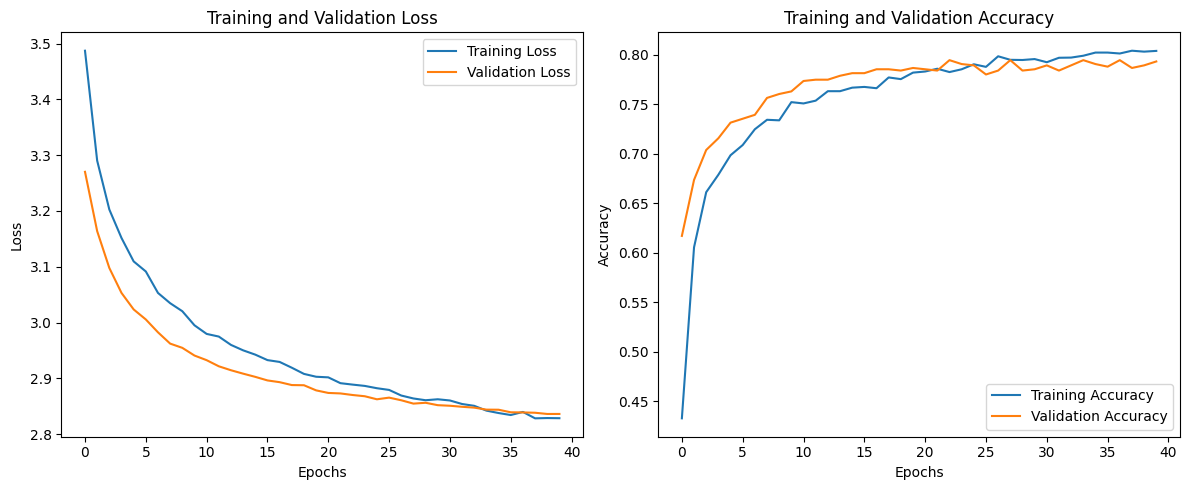

In [14]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')


# Train the model with the callbacks
history = model_train.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=40, 
                    batch_size=256, 
                    callbacks=[model_checkpoint])


# Plot loss
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accu
plt.subplot(1, 2, 2)
plt.plot(history.history.get('accuracy', []), label='Training Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('training_validation_plot.jpeg', format='jpeg')

plt.tight_layout()
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Accuracy: 0.8177083333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81       129
           1       0.77      0.68      0.72       129
           2       0.87      0.95      0.91       126

    accuracy                           0.82       384
   macro avg       0.81      0.82      0.82       384
weighted avg       0.81      0.82      0.81       384



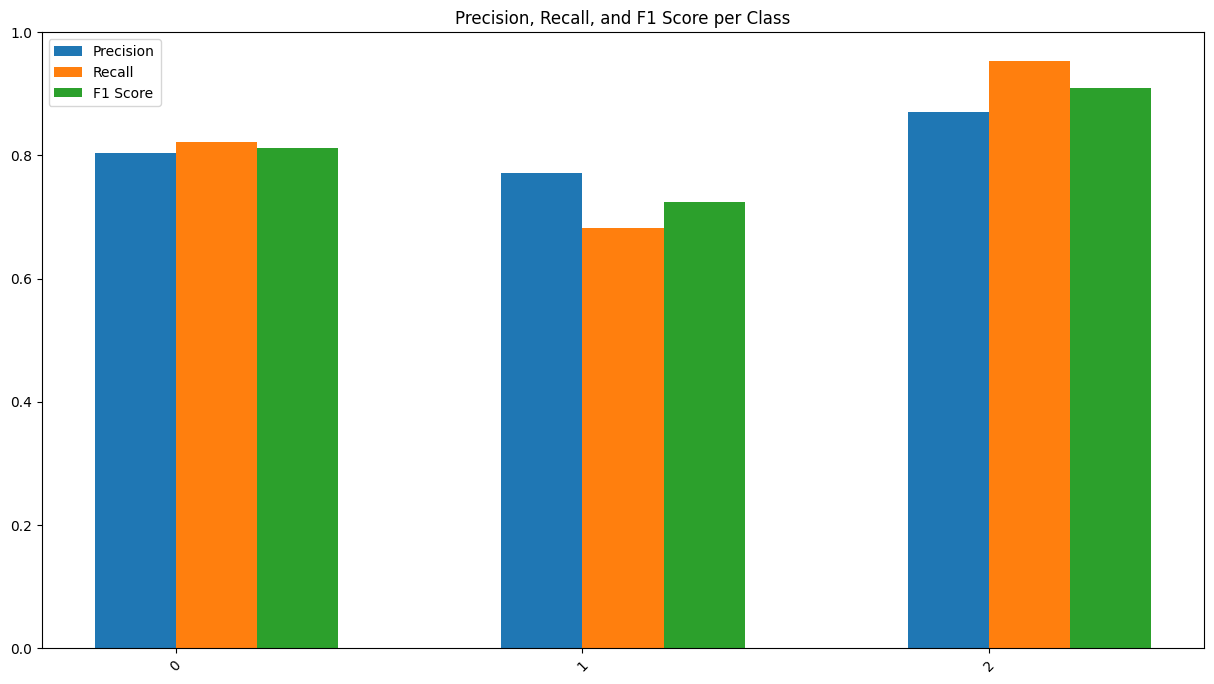

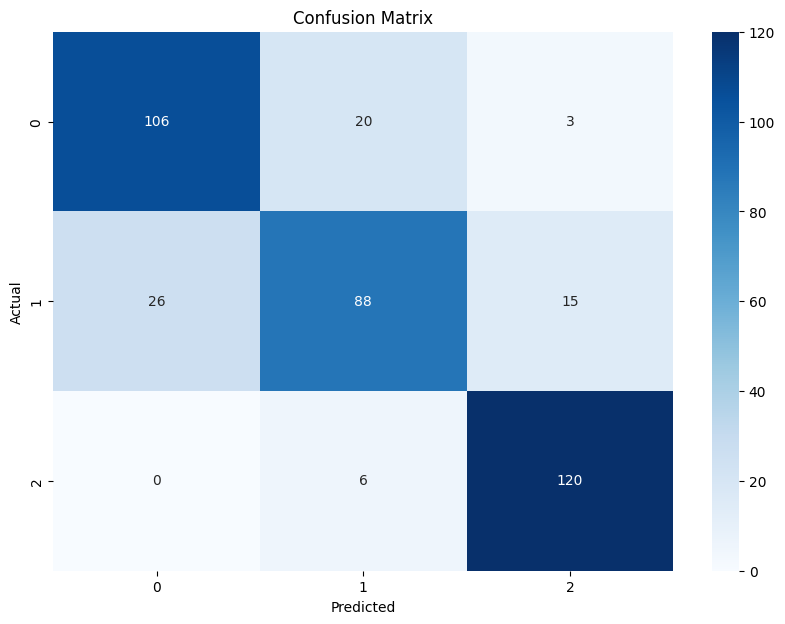

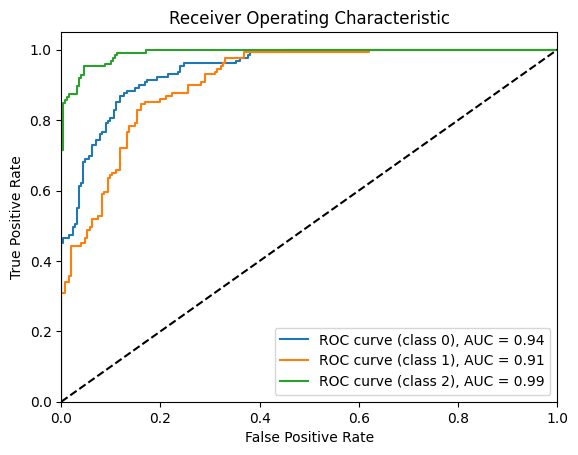

In [15]:
import os
import numpy as np
from keras.models import load_model
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_recall_fscore_support, roc_curve, auc)
import seaborn as sns
import matplotlib.pyplot as plt

# Load your trained model
model = load_model('/kaggle/working/best_model.keras')

# Load the test features and labels
test_features = np.load('/kaggle/input/vgg16-selected-features/X_test_selected.npy')
test_labels = np.load('/kaggle/input/vgg16-selected-features/y_test.npy')

test_features = scaler.transform(test_features)

# Get class names from the test set directory
test_folder = '/kaggle/input/balanced-training-data/new_balanced_dataset/test'
class_names = sorted(os.listdir(test_folder))

# Make predictions
predictions = model.predict(test_features)
predicted_classes = np.argmax(predictions, axis=1)

# Evaluate the model
accuracy = accuracy_score(test_labels, predicted_classes)
report = classification_report(test_labels, predicted_classes, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# Calculate Precision, Recall, F1 Score per class
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_classes, average=None)

# Create a bar graph
plt.figure(figsize=(15, 8))
class_names_list = list(class_names)  # Convert class_names to a list for indexing

# Set width for each bar (adjust as needed)
bar_width = 0.20

# Create bar positions for each metric
x_axis = np.arange(len(class_names))  # Positions for bars

# Plot Precision bars
plt.bar(x_axis - bar_width/2, precision, bar_width, label='Precision')

# Plot Recall bars (shifted to the right)
plt.bar(x_axis + bar_width/2, recall, bar_width, label='Recall')

# Plot F1 Score bars (shifted further to the right)
plt.bar(x_axis + 3*bar_width/2, f1, bar_width, label='F1 Score')

# Set x-axis labels with rotation
plt.xticks(x_axis, class_names_list, rotation=45)
plt.ylim(0, 1)  # Adjust y-axis limits as needed
plt.legend()
plt.title('Precision, Recall, and F1 Score per Class')
plt.savefig('precision recall and f1 score graph.jpeg', format='jpeg')
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.jpeg', format='jpeg')
plt.show()

# Calculate ROC curve and AUC
from sklearn.preprocessing import label_binarize

# Binarize the output
y_test_bin = label_binarize(test_labels, classes=range(len(class_names)))
y_score = predictions

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {class_names[i]}), AUC = {roc_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig('AUCROC.jpeg', format='jpeg')
plt.show()



In [16]:
import pickle
# Replace 'path_to_model.pkl' with the path to your pickle file
with open('/kaggle/input/vgg16-selected-features/boruta_selector.pkl', 'rb') as file:
    boruta_selector = pickle.load(file)
selected_feature_indices = boruta_selector.support_

print(selected_feature_indices)

test_folder = '/kaggle/input/balanced-training-data/new_balanced_dataset/test'
class_names = sorted(os.listdir(test_folder))

[ True  True  True  True  True  True  True False  True False  True  True
 False  True  True False  True False  True  True  True  True False  True
  True  True  True False  True  True  True  True False  True  True  True
  True  True  True  True False  True  True  True  True  True  True False
  True  True  True False  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True False  True  True  True False  True
  True False  True  True  True  True  True  True  True  True False  True
 False  True  True  True  True False  True  True  True False False  True
  True  True  True  True  True  True False  True  True  True False False
 False  True  True  True  True  True  True  True  True False False False
 False  True  True  True  True  True  True  True False  True  True  True
 False  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True False  True False  T

In [17]:
# Load your trained models
classification_model = load_model('/kaggle/working/best_model.keras')  # Replace with your classification model path

# Single image path you want to predict
single_image_path = '/kaggle/input/balanced-training-data/new_balanced_dataset/test/1/1 (1126).png'  # Replace with your single image path

# Extract features for the single image using the function
single_image_features = extract_features_from_image(single_image_path, feature_extraction_model)

# Ensure features are reshaped or flattened appropriately
single_image_features = single_image_features.reshape(1, -1)  # Reshape to (1, 512), adjust 512 as per actual feature size

# Filter the validation features
single_image_features = single_image_features[:, selected_feature_indices]

# Perform any necessary scaling (if `scaler` is defined elsewhere)
single_image_features = scaler.transform(single_image_features)

# Predict using your classification model
predicted_probabilities = classification_model.predict(single_image_features)
predicted_class_index = np.argmax(predicted_probabilities, axis=1)[0]  # Assuming single prediction
predicted_class = class_names[predicted_class_index]  # Replace `class_names` with your actual class names list

print("Predicted class:", predicted_class)
print(predicted_probabilities)

2024-07-20 05:49:16.121582: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.42855, expected 3.64542
2024-07-20 05:49:16.121635: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.87036, expected 5.08723
2024-07-20 05:49:16.121650: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.04003, expected 5.2569
2024-07-20 05:49:16.121663: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.22034, expected 5.43722
2024-07-20 05:49:16.121676: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.90026, expected 4.11714
2024-07-20 05:49:16.121686: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.21068, expected 4.42756
2024-07-20 05:49:16.121697: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.92061, expected 5.13748
2024-07-20 05:49:16.121708: E external/local_xla/xla/ser

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Predicted class: 1
[[0.0108342 0.6153184 0.3738474]]
